In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from forecasting.data_prep import classify_demand_profile, find_closest_stable_period

from xgboost import XGBRegressor
from scipy.stats import ks_2samp
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

import matplotlib as mpl
mpl.rcParams["figure.dpi"] = 300

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

ImportError: cannot import name 'find_closest_stable_period' from 'forecasting.data_prep' (/Users/katecastillo/Documents/MSDS/msds-git-projects/machine-learning2/wesm-demand/forecasting/data_prep.py)

In [4]:
rtd = pd.read_csv("data/rtd_reduced.csv")
rtd["run_time"] = pd.to_datetime(rtd["run_time"])

rtd.sort_values("run_time", inplace=True)
rtd.dropna(inplace=True)

rtd["hour"] = rtd["run_time"].dt.hour
rtd["day"] = rtd["run_time"].dt.day
rtd["dayofweek"] = rtd["run_time"].dt.dayofweek
rtd["month"] = rtd["run_time"].dt.month

In [5]:
rtd

,run_time,mkt_reqt,hour,day,dayofweek,month
0,2022-01-01 00:00:00+00:00,8209.66,0,1,5,1
1,2022-01-01 00:05:00+00:00,8241.92,0,1,5,1
2,2022-01-01 00:10:00+00:00,8171.55,0,1,5,1
3,2022-01-01 00:15:00+00:00,8124.73,0,1,5,1
4,2022-01-01 00:20:00+00:00,8129.98,0,1,5,1
...,...,...,...,...,...,...
331872,2025-02-28 23:30:00+00:00,12018.14,23,28,4,2
331873,2025-02-28 23:35:00+00:00,11977.23,23,28,4,2
331874,2025-02-28 23:40:00+00:00,11937.51,23,28,4,2
331875,2025-02-28 23:45:00+00:00,11884.45,23,28,4,2


## 2023 Data

### Define Demand Profiles

In [8]:
filter_df = rtd[(rtd["run_time"]>="2023-01-01") & (rtd["run_time"]<"2024-01-01")]
df = filter_df.copy()

Decompose time-series

In [9]:
rolling_window_size = 288 * 4 # 4-day rolling window

stl = STL(df["mkt_reqt"], period=288, robust=True)
result = stl.fit()

df["trend"] = result.trend
df["residual"] = result.resid

df["trend_change"] = df["trend"].diff().rolling(rolling_window_size).std()

Assess trend changes

In [10]:

q1, q2, q3 = df["trend_change"].quantile([0.25, 0.5, 0.75])

df["demand_profile"] = df["trend_change"].apply(lambda x: classify_demand_profile(x, q1, q2, q3))

df["profile_change"] = df["demand_profile"] != df["demand_profile"].shift(1)
df["segment_id"] = np.cumsum(df["profile_change"])
df.drop(columns=["profile_change"], inplace=True)

df["subset_number"] = df.groupby("demand_profile")["segment_id"].rank(method="dense").astype(int)

df_profiles = df.groupby(["demand_profile", "subset_number"]).agg(
    time_index=("run_time", list),
    time_series_subset=("mkt_reqt", list), 
    subset_length=("mkt_reqt", "count"),
).reset_index()

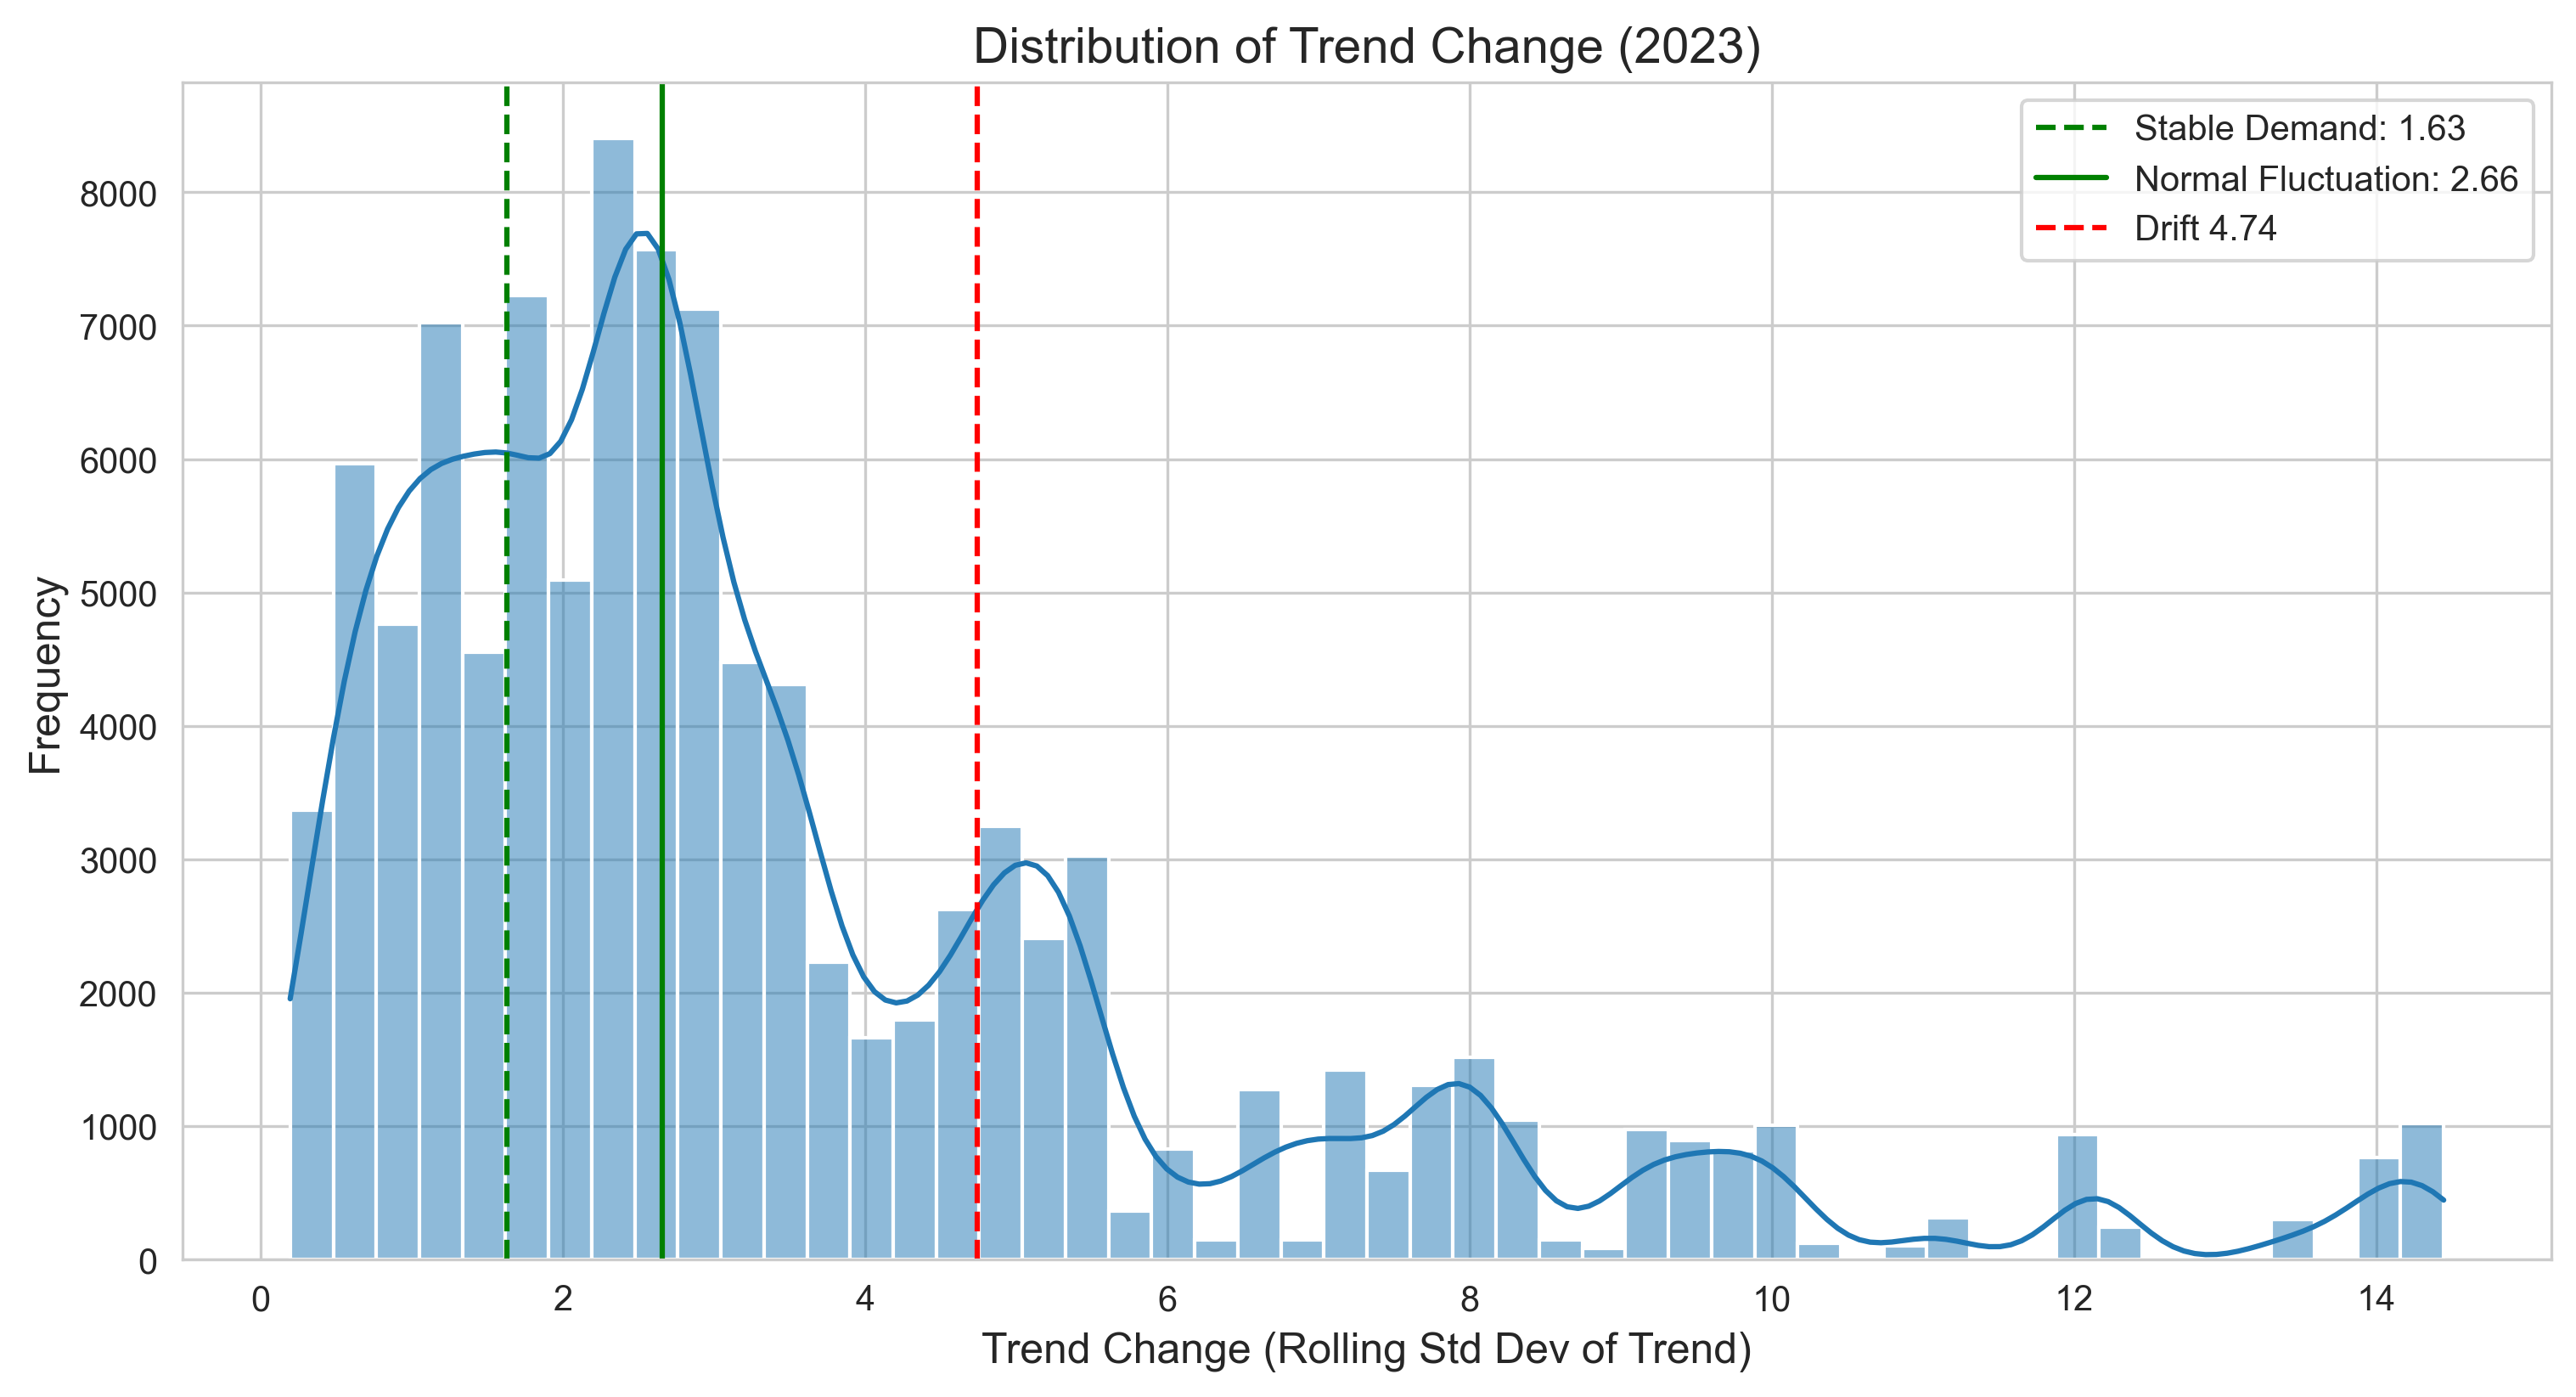

In [11]:
sns.set_style("whitegrid")

plt.figure(figsize=(12, 6))
sns.histplot(df["trend_change"].dropna(), bins=50, kde=True, )

plt.axvline(q1, color="green", linestyle="dashed", label=f"Stable Demand: {q1:.2f}")
plt.axvline(q2, color="green", label=f"Normal Fluctuation: {q2:.2f}")
plt.axvline(q3, color="red", linestyle="dashed", label=f"Drift {q3:.2f}")

plt.xlabel("Trend Change (Rolling Std Dev of Trend)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Distribution of Trend Change (2023)", fontsize=14)
plt.legend()

# Show plot
plt.show()

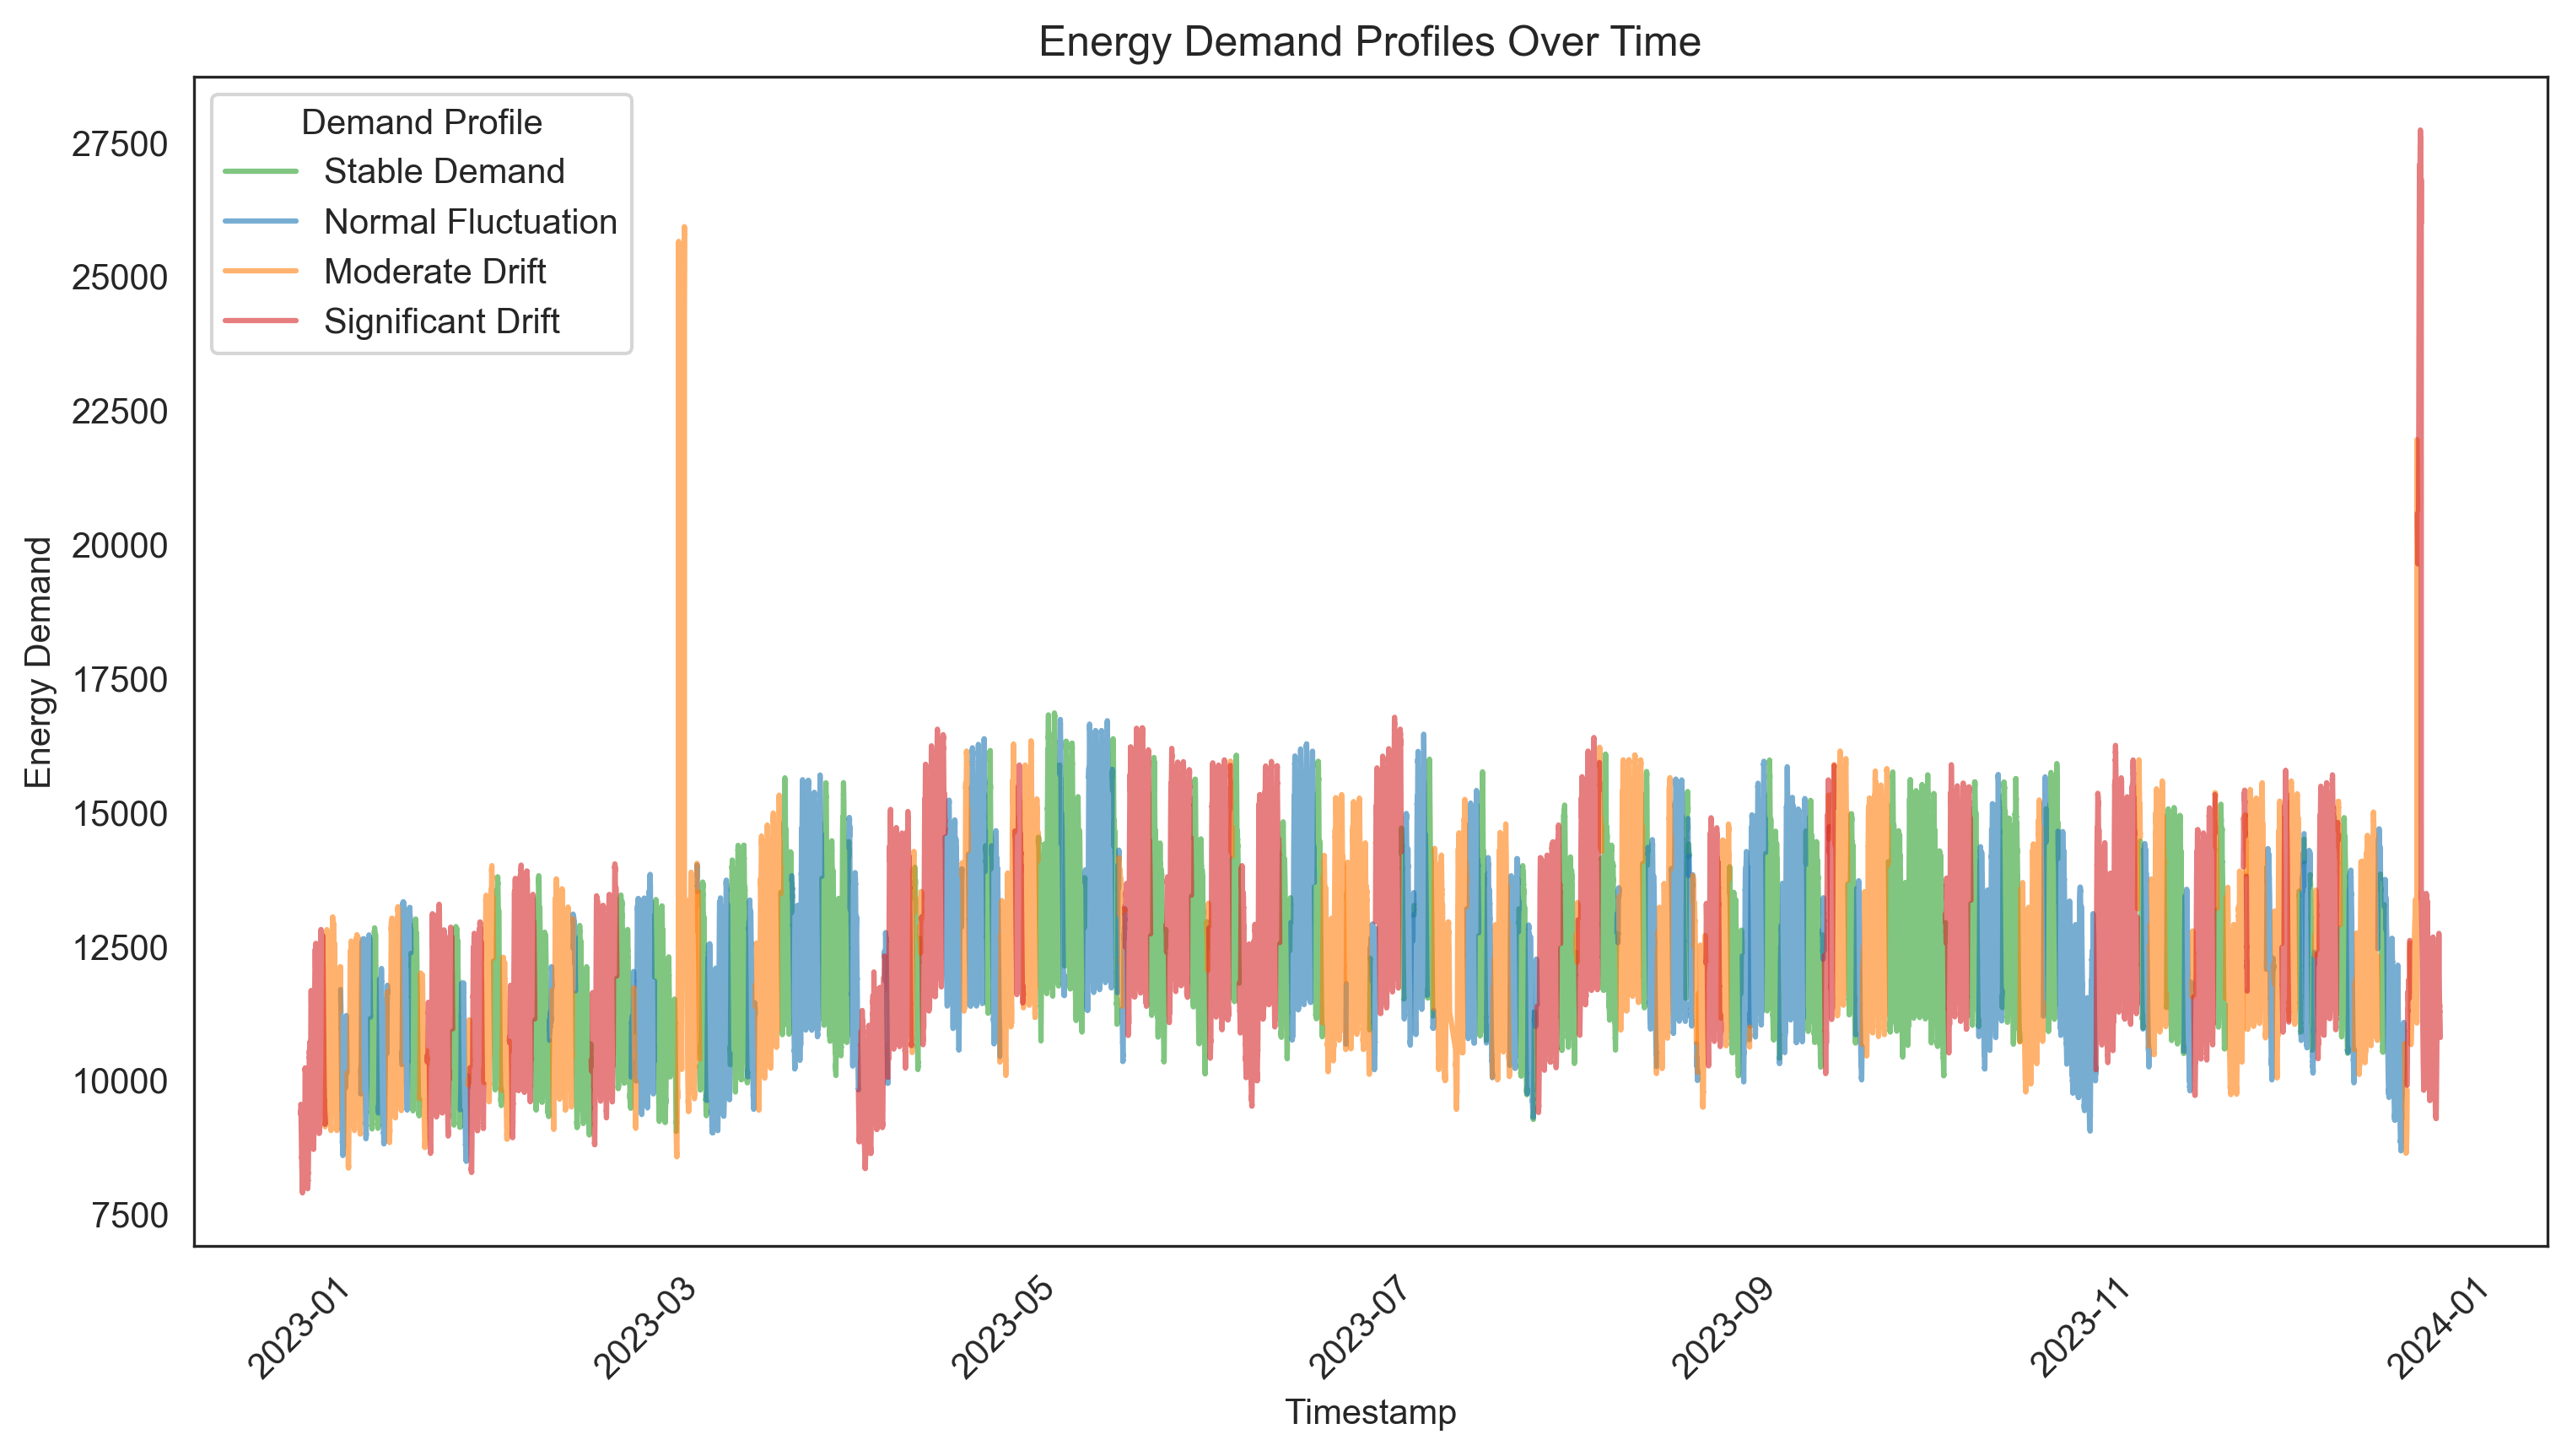

In [ ]:
sns.set_style("white")
plt.figure(figsize=(12, 6))

palette = sns.color_palette("tab10", n_colors=df_profiles["demand_profile"].nunique())
profile_colors = dict(zip(df_profiles["demand_profile"].unique(), palette))

profile_colors = {
    "Stable Demand": palette[2],     
    "Normal Fluctuation": palette[0],
    "Moderate Drift": palette[1],    
    "Significant Drift": palette[3], 
}

for profile, color in profile_colors.items():
    subset = df_profiles[df_profiles["demand_profile"] == profile]

    for _, row in subset.iterrows():
        plt.plot(row["time_index"], row["time_series_subset"], color=color, alpha=0.6, label=profile)

plt.xlabel("Timestamp")
plt.ylabel("Energy Demand")
plt.title("Energy Demand Profiles Over Time")
plt.xticks(rotation=45)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title="Demand Profile",)

plt.show()

<Figure size 3600x1800 with 0 Axes>

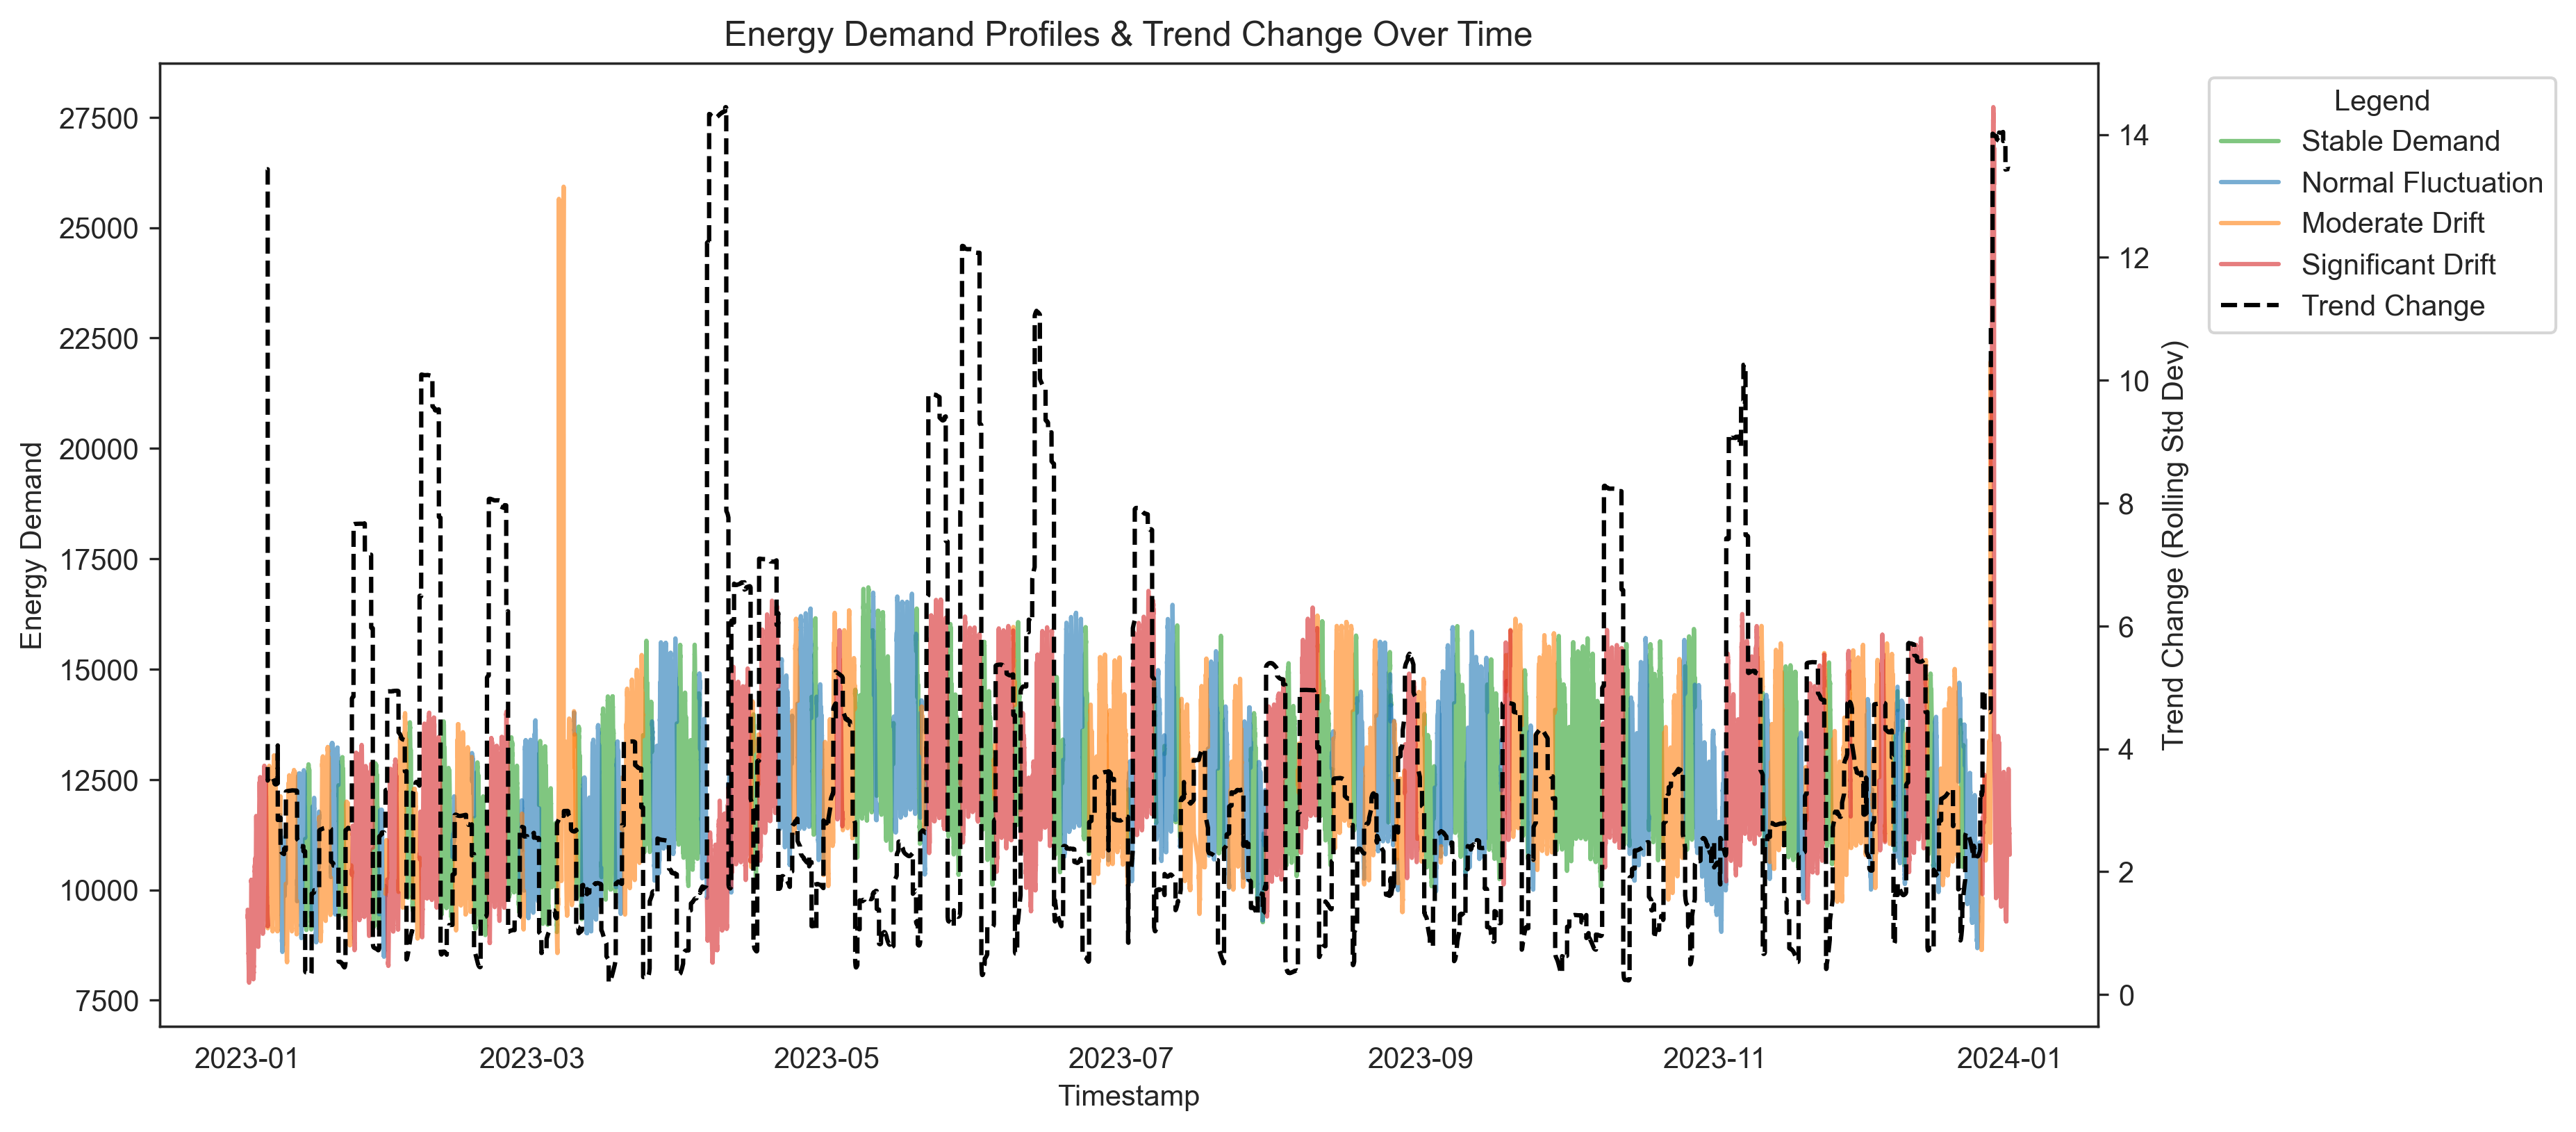

In [14]:
sns.set_style("white")
plt.figure(figsize=(12, 6))
fig, ax1 = plt.subplots(figsize=(12, 6))

palette = sns.color_palette("tab10")
profile_colors = {
    "Stable Demand": palette[2],       # Green
    "Normal Fluctuation": palette[0],  # Blue
    "Moderate Drift": palette[1],      # Orange
    "Significant Drift": palette[3],   # Red
}

for profile, color in profile_colors.items():
    subset = df_profiles[df_profiles["demand_profile"] == profile]

    for _, row in subset.iterrows():
        ax1.plot(row["time_index"], row["time_series_subset"], color=color, alpha=0.6, label=profile)

ax1.set_xlabel("Timestamp")
ax1.set_ylabel("Energy Demand")
ax1.set_title("Energy Demand Profiles & Trend Change Over Time")

ax2 = ax1.twinx()
ax2.plot(df["run_time"], df["trend_change"], color="black", linestyle="dashed", linewidth=1.5, label="Trend Change")

ax2.set_ylabel("Trend Change (Rolling Std Dev)")

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
by_label = dict(zip(labels1 + labels2, handles1 + handles2))
ax1.legend(by_label.values(), by_label.keys(), title="Legend", loc="upper left", bbox_to_anchor=(1.05, 1))

plt.xticks(rotation=45)
plt.show()

## Generate Counterfactuals

In [15]:
drift_periods = df_profiles[~df_profiles["demand_profile"].isin(["Stable Demand", "Normal Fluctuation"])]
stable_periods = df_profiles[df_profiles["demand_profile"].isin(["Stable Demand", "Normal Fluctuation"])]

In [23]:
from fastdtw import fastdtw

def find_closest_stable_period(target_series, stable_periods):
    min_distance = float("inf")
    best_match = None

    for _, row in stable_periods.iterrows():
        stable_series = row["time_series_subset"]

        # Compute DTW distance (handles different lengths)
        dist, _ = fastdtw(target_series, stable_series)

        if dist < min_distance:
            min_distance = dist
            best_match = stable_series

    return best_match if best_match is not None else target_series

In [24]:
counterfactual_series = []

for _, row in df_profiles.iterrows():
    if row["demand_profile"] == "Stable Demand":
        counterfactual_series.append(row["time_series_subset"])  # keep original
    else:
        stable_match = find_closest_stable_period(row["time_series_subset"], stable_periods)
        counterfactual_series.append(stable_match)  # replace with similar stable period

df_profiles["counterfactual_series"] = counterfactual_series
df_profiles["counterfactual_length"] = df_profiles["counterfactual_series"].apply(lambda x: len(x))

In [25]:
def adjust_length(series, target_length):
    """
    Adjusts the series length to match the target length using interpolation or padding.
    """
    series = pd.Series(series)

    if len(series) < target_length:
        series_interp = series.interpolate(method="linear")
        series_padded = np.pad(series_interp, (0, target_length - len(series_interp)), mode="edge")
    elif len(series) > target_length:
        series_padded = series.iloc[:target_length].values
    else:
        series_padded = series.values

    return series_padded.tolist()

In [26]:
df_profiles["new_counterfactual_series"] = df_profiles.apply(
    lambda row: adjust_length(row["counterfactual_series"], row["subset_length"]), axis=1
)

df_profiles["new_counterfactual_length"] = df_profiles["new_counterfactual_series"].apply(len)

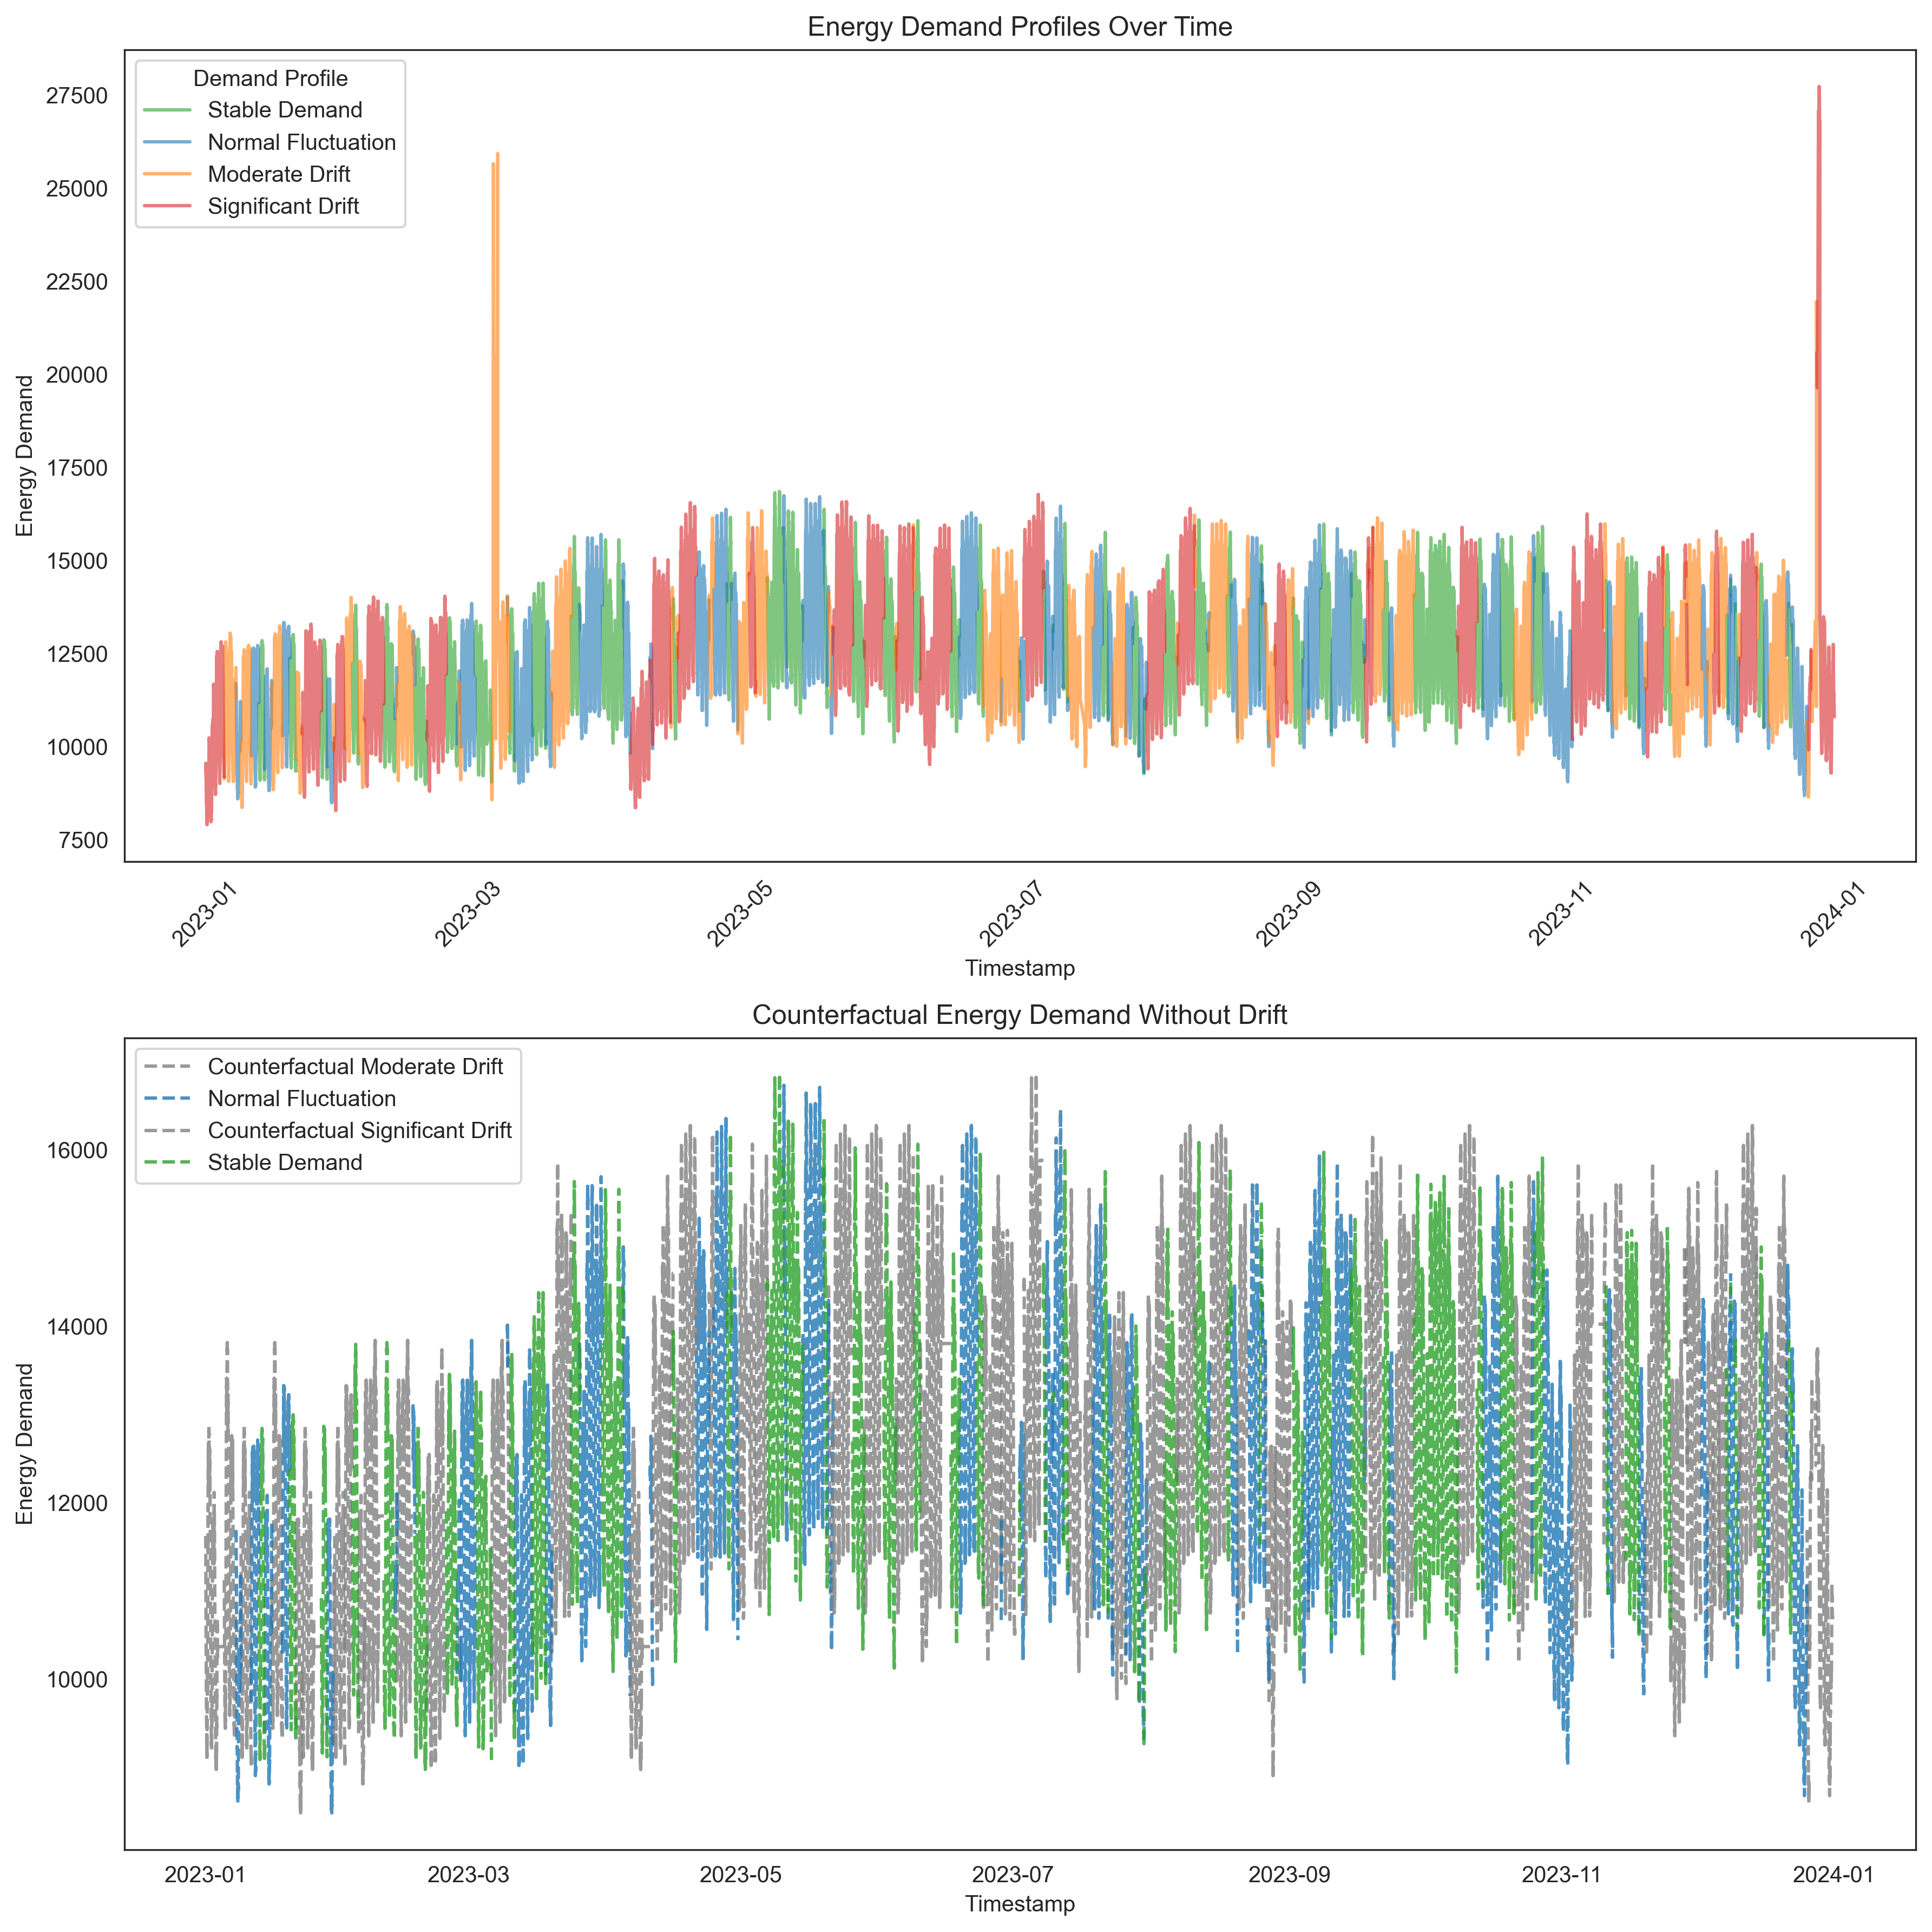

In [29]:
sns.set_style("white")
fig, axes = plt.subplots(2, 1, figsize=(12, 12))  # Two subplots (stacked)

# Define color palette
palette = sns.color_palette("tab10", n_colors=df_profiles["demand_profile"].nunique())

# Map profiles to colors
profile_colors = {
    "Stable Demand": palette[2],     
    "Normal Fluctuation": palette[0],
    "Moderate Drift": palette[1],    
    "Significant Drift": palette[3], 
}

### **Subplot 1: Energy Demand Profiles Over Time**
for profile, color in profile_colors.items():
    subset = df_profiles[df_profiles["demand_profile"] == profile]
    
    for _, row in subset.iterrows():
        axes[0].plot(row["time_index"], row["time_series_subset"], color=color, alpha=0.6, label=profile)

axes[0].set_xlabel("Timestamp")
axes[0].set_ylabel("Energy Demand")
axes[0].set_title("Energy Demand Profiles Over Time")
axes[0].tick_params(axis="x", rotation=45)

# Remove duplicate labels
handles, labels = axes[0].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
axes[0].legend(by_label.values(), by_label.keys(), title="Demand Profile")

### **Subplot 2: Counterfactual Energy Demand Without Drift**
counterfactual_colors = {
    "Stable Demand": palette[2],       
    "Normal Fluctuation": palette[0],  
    # "Counterfactual Moderate Drift": palette[1],    
    # "Counterfactual Significant Drift": palette[3],  
}

for profile in df_profiles["demand_profile"].unique():
    subset = df_profiles[df_profiles["demand_profile"] == profile]
    
    first_counterfactual = True  # Flag for the first label

    for _, row in subset.iterrows():
        if profile in ["Stable Demand", "Normal Fluctuation"]:
            label = profile if first_counterfactual else ""
            color = counterfactual_colors[profile]
        else:
            label = f"Counterfactual {profile}" if first_counterfactual else ""
            color = counterfactual_colors.get(f"Counterfactual {profile}", "gray")

        axes[1].plot(row["time_index"], row["new_counterfactual_series"], linestyle="dashed", alpha=0.8, color=color, label=label)
        first_counterfactual = False  

axes[1].set_xlabel("Timestamp")
axes[1].set_ylabel("Energy Demand")
axes[1].set_title("Counterfactual Energy Demand Without Drift")
axes[1].legend()

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

In [30]:
# plt.figure(figsize=(12, 6))

# profile_colors = {
#     "Stable Demand": palette[2],       # Green
#     "Normal Fluctuation": palette[0],  # Blue
#     "Counterfactual Moderate Drift": palette[1],      # Orange
#     "Counterfactual Significant Drift": palette[3],   # Red
# }

# for profile in df_profiles["demand_profile"].unique():
#     subset = df_profiles[df_profiles["demand_profile"] == profile]
    
#     first_counterfactual = True  # Flag to track the first counterfactual label

#     for _, row in subset.iterrows():
#         # Define label logic
#         if profile in ["Stable Demand", "Normal Fluctuation"]:
#             label = profile if first_counterfactual else ""
#             color = profile_colors[profile]
#         else:
#             label = f"Counterfactual {profile}" if first_counterfactual else ""
#             color = profile_colors.get(f"Counterfactual {profile}", "gray")  # Default to gray if missing

#         # Plot counterfactual series with assigned color
#         plt.plot(row["time_index"], row["new_counterfactual_series"], linestyle="dashed", alpha=0.8, color=color, label=label)
#         first_counterfactual = False  # Disable label after first occurrence

# plt.xlabel("Timestamp")
# plt.ylabel("Energy Demand")
# plt.legend()
# plt.title("Counterfactual Energy Demand Without Drift")
# plt.show()

In [31]:
df_profiles["drift_impact"] = df_profiles["time_series_subset"].apply(np.mean) - df_profiles["counterfactual_series"].apply(np.mean)
df_profiles[["demand_profile", "drift_impact"]]

,demand_profile,drift_impact
0,Moderate Drift,-127.839811
1,Moderate Drift,59.234965
2,Moderate Drift,-39.715431
3,Moderate Drift,215.519404
4,Moderate Drift,150.037709
...,...,...
181,Stable Demand,0.000000
182,Stable Demand,0.000000
183,Stable Demand,0.000000
184,Stable Demand,0.000000


In [32]:
def calculate_errors(df):
    mae_list = []
    mse_list = []
    rmse_list = []
    mape_list = []
    
    for _, row in df.iterrows():
        actual = np.array(row["time_series_subset"])
        counterfactual = np.array(row["counterfactual_series"])
        
        # Ensure both arrays have the same length
        min_len = min(len(actual), len(counterfactual))
        actual = actual[:min_len]
        counterfactual = counterfactual[:min_len]

        # Compute error metrics
        mae = np.mean(np.abs(actual - counterfactual))
        mse = np.mean((actual - counterfactual) ** 2)
        rmse = np.sqrt(mse)

        # MAPE (Avoid division by zero)
        mask = actual != 0  # Ignore cases where actual demand is zero
        if np.any(mask):
            mape = np.mean(np.abs((actual[mask] - counterfactual[mask]) / actual[mask])) * 100
        else:
            mape = np.nan  # Assign NaN if all actual values are zero
        
        mae_list.append(mae)
        mse_list.append(mse)
        rmse_list.append(rmse)
        mape_list.append(mape)
    
    # Compute overall metrics
    overall_mae = np.mean(mae_list)
    overall_mse = np.mean(mse_list)
    overall_rmse = np.mean(rmse_list)
    overall_mape = np.nanmean(mape_list)  # Use nanmean to ignore NaN values

    return overall_mae, overall_mse, overall_rmse, overall_mape

# Compute error metrics
mae, mse, rmse, mape = calculate_errors(df_profiles)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Mean Absolute Error (MAE): 482.80
Mean Absolute Percentage Error (MAPE): 3.86%
Mean Squared Error (MSE): 1218160.63
Root Mean Squared Error (RMSE): 578.45


In [44]:
feature_cols = ["time_index", "time_series_subset", "new_counterfactual_series"]

df_counterfactuals = df_profiles.explode(feature_cols)[feature_cols]
df_counterfactuals.columns = ["run_time", "actual_demand", "counterfactual_demand"]
df_counterfactuals[["actual_demand", "counterfactual_demand"]] = df_counterfactuals[["actual_demand", "counterfactual_demand"]].astype(float)

df_counterfactuals.sort_values("run_time", inplace=True)

In [49]:
df_train = pd.merge(df_counterfactuals, df[["run_time", "hour", "day", "dayofweek", "month"]], on="run_time")
df_train

,run_time,actual_demand,counterfactual_demand,hour,day,dayofweek,month
0,2023-01-01 00:00:00+00:00,9549.94,11624.22,0,1,6,1
1,2023-01-01 00:05:00+00:00,9533.03,11595.37,0,1,6,1
2,2023-01-01 00:10:00+00:00,9523.40,11551.05,0,1,6,1
3,2023-01-01 00:15:00+00:00,9408.86,11454.51,0,1,6,1
4,2023-01-01 00:20:00+00:00,9411.26,11413.04,0,1,6,1
...,...,...,...,...,...,...,...
104456,2023-12-31 23:35:00+00:00,10957.28,10702.49,23,31,6,12
104457,2023-12-31 23:40:00+00:00,10936.45,10702.49,23,31,6,12
104458,2023-12-31 23:45:00+00:00,10906.39,10702.49,23,31,6,12
104459,2023-12-31 23:50:00+00:00,10889.28,10702.49,23,31,6,12
